# Work through Geometric Factor for Sullivan 1971 
* How do the results depend on stackup?
    * Both the full formula and a bounded formula
* How do the results depend on diameter?
    * Both the full formula and a bounded formula
    
$G=\frac{1}{2}\pi^2 \left[R_1^2+R_2^2+l^2 -\left\{\left(R_1^2+R_2^2+l^2\right)^2-4R_1^2R_2\right\}^{\frac{1}{2}}   \right]$

$G \ge \frac{A_1A_2}{R_1^2+R_2^2+l^2}$

In [1]:
from pprint import pprint 

import numpy as np
import pymc3 as mc3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 3})

/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def getBoundedNormal_dist(mean=None, FWHM=None, name=None, lower=0, upper=1e6):
    """
    Make a bounded normal distribution

    NOTE: https://github.com/pymc-devs/pymc3/issues/1672 bounded dist fail until 3.1 on
    non array bounds!!
    """
    assert mean is not None
    assert FWHM is not None
    assert name is not None
    BoundedNormal = mc3.Bound(mc3.Normal, lower=np.asanyarray(lower), upper=np.asanyarray(upper))
    return BoundedNormal('{0}'.format(name), mu=mean, sd=FWHMtoSD_Normal(mean * (FWHM / 100.)))

def Sullivan_Bound(R1, R2, l):
    A1 = np.pi*R1**2
    A2 = np.pi*R2**2
    top = A1*A2
    bottom = R1**2+R2**2+l**2
    return top/bottom

def Sullivan(R1, R2, l):
    f = 0.5*np.pi**2
    t1 = R1**2+R2**2+l**2
    t2 = 4*R1**2*R2**2
    G = f*(t1 - (t1**2-t2)**0.5 )
    return G

def frac_bounds(trace):
    med = np.median(trace)
    bounds = np.percentile(trace, (2.5, 97.5))
    frac = (med-bounds[0])/med
    return med, frac*100

## Just thickness
### Stack up five colimator discs to compute G  

In [3]:
Sullivan(4, 5, 10)

28.586083706031708

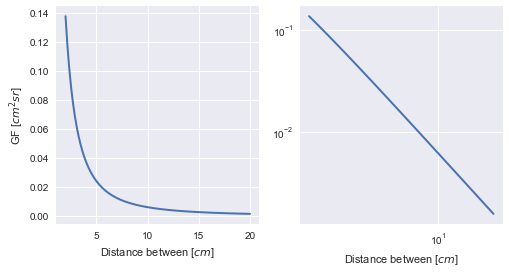

In [4]:
R1 = 0.5
R2 = 0.5
l = np.linspace(2, 20, 100)
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].plot(l, Sullivan(R1, R2, l), lw=2)
ax[0].set_xlabel('Distance between [$cm$]')
ax[0].set_ylabel('GF [$cm^2sr$]');

ax[1].loglog(l, Sullivan(R1, R2, l), lw=2)
ax[1].set_xlabel('Distance between [$cm$]');


In [5]:
with mc3.Model() as model1:
    T1 = mc3.Normal('T1', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    T2 = mc3.Normal('T2', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    T3 = mc3.Normal('T3', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    T4 = mc3.Normal('T4', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    T5 = mc3.Normal('T5', 1.0, tau=(0.1e-2)**-2)  # 1cm +/- 0.1mm
    R1 = 0.5
    R2 = 0.5
    R3 = 0.5
    G = mc3.Deterministic('G', Sullivan(R1, R3, T1+T2+T3+T4+T5))
    Gbound = mc3.Deterministic('Gbound', Sullivan_Bound(R1, R3, T1+T2+T3+T4+T5))
    start = mc3.find_MAP()
    trace = mc3.sample(10000, start=start, jobs=2)
    

logp = 29.944, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 430.76it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:12<00:00, 874.16it/s]


In [6]:
mc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
T1,1.000003,0.000995,6.196923e-06,0.998090,1.001971,20000.0,0.999986
T2,1.000002,0.000989,5.436159e-06,0.998165,1.002012,20000.0,0.999991
T3,1.000002,0.001000,5.411114e-06,0.998063,1.001973,20000.0,1.000046
T4,1.000002,0.000994,4.592042e-06,0.998059,1.001945,20000.0,0.999951
T5,0.999983,0.001007,4.342660e-06,0.998000,1.001915,20000.0,1.000130
G,0.024193,0.000021,1.059518e-07,0.024151,0.024234,20000.0,1.000221
Gbound,0.024190,0.000021,1.059213e-07,0.024149,0.024231,20000.0,1.000221


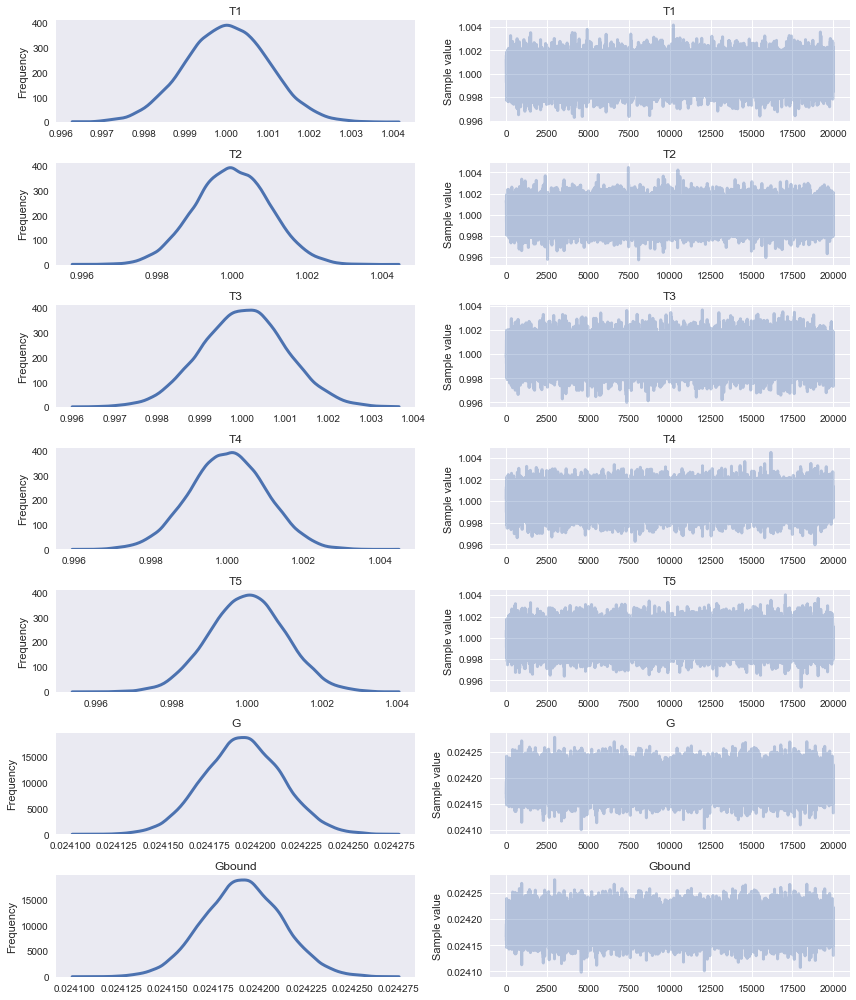

In [7]:
mc3.traceplot(trace, combined=True);

In [8]:
gf = frac_bounds(trace['G'])
gbf = frac_bounds(trace['Gbound'])
print("G={:.5f} +/- {:.2f}%".format(gf[0], gf[1]))
print("Gbound={:.5f} +/- {:.2f}%".format(gbf[0], gbf[1]))

G=0.02419 +/- 0.17%
Gbound=0.02419 +/- 0.17%


## As a function of measurement uncertainty

In [9]:
pm = np.logspace(-3, -1, 10)
ans = {}
for ii, p in enumerate(pm):
    print(p, ii+1, len(pm))
    with mc3.Model() as model2:
        T1 = mc3.Normal('T1', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        T2 = mc3.Normal('T2', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        T3 = mc3.Normal('T3', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        T4 = mc3.Normal('T4', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        T5 = mc3.Normal('T5', 1.0, tau=(p)**-2)  # 1cm +/- 0.1mm
        R1 = 0.5
        R2 = 0.5
        R3 = 0.5
        G = mc3.Deterministic('G', Sullivan(R1, R3, T1+T2+T3+T4+T5))
        Gbound = mc3.Deterministic('Gbound', Sullivan_Bound(R1, R3, T1+T2+T3+T4+T5))
        start = mc3.find_MAP()
        trace = mc3.sample(10000, start=start, jobs=2)
        ans[p] = gf = frac_bounds(trace['G'])


0.001


logp = 29.944, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 612.35it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/blarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:12<00:00, 827.25it/s]


0.0016681005372000592


logp = 27.386, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 542.85it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:12<00:00, 813.61it/s]


0.0027825594022071257


logp = 24.827, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 655.51it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:12<00:00, 830.53it/s]


0.004641588833612777


logp = 22.269, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 570.46it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:13<00:00, 790.81it/s]


0.007742636826811269


logp = 19.71, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 443.98it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:11<00:00, 896.42it/s]


0.01291549665014884


logp = 17.152, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 485.20it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:14<00:00, 747.16it/s]


0.021544346900318832


logp = 14.594, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 516.79it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:13<00:00, 791.32it/s]


0.03593813663804626


logp = 12.035, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 642.66it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:11<00:00, 893.88it/s]


0.05994842503189409


logp = 9.4767, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 826.14it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:12<00:00, 863.21it/s]


0.1


logp = 6.9182, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 673.24it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T5, T4, T3, T2, T1]
100%|██████████| 10500/10500 [00:12<00:00, 820.20it/s]


In [13]:
pprint(ans)

{0.001: (0.024192759626860932, 0.16887108217994137),
 0.0016681005372000592: (0.02419265165377432, 0.288399631972334),
 0.0027825594022071257: (0.024192343575918984, 0.47542877438588743),
 0.004641588833612777: (0.024191770919360304, 0.7919229309741671),
 0.007742636826811269: (0.024191041709859612, 1.3138360376080616),
 0.01291549665014884: (0.02419309085285451, 2.190803885401746),
 0.021544346900318832: (0.024195168800404877, 3.6201748973020385),
 0.03593813663804626: (0.024192707603758953, 5.862407618035852),
 0.05994842503189409: (0.024200445302202125, 9.56567699473629),
 0.1: (0.02418403908851534, 15.146382536866302)}


In [15]:
vals = np.asarray(list(ans.keys()))
gs = np.asarray([ans[v][0] for v in ans ])
gse = np.asarray([ans[v][1] for v in ans ])


(0, 15)

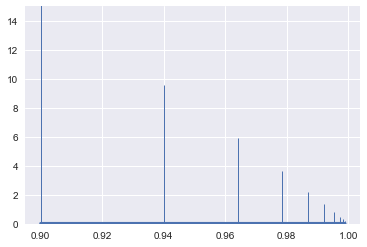

In [32]:
valsf = (1.0-vals)/1.0
plt.errorbar(valsf, gs, yerr=gse, elinewidth=1, capsize=2, barsabove=True)
plt.ylim([0,15])
# plt.xscale('log')

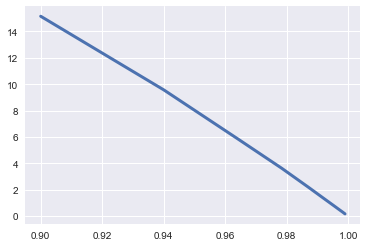

In [34]:
plt.plot(valsf, gse)
